In [5]:
import json
import os
import random
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from nnsight import CONFIG, LanguageModel
from torch.utils.data import DataLoader
from tqdm import tqdm

from utils import error_detection, get_visibility_lookback_data

sys.path.append("../..")
from src.dataset import STORY_TEMPLATES, Dataset, Sample
from src.utils import env_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(10)

CONFIG.APP.REMOTE_LOGGING = True

os.environ["NDIF_KEY"] = env_utils.load_env_var("NDIF_KEY")
os.environ["HF_TOKEN"] = env_utils.load_env_var("HF_WRITE")

# Loading Synthetic Data

In [2]:
all_characters = json.load(
    open(
        os.path.join(
            env_utils.DEFAULT_DATA_DIR, "synthetic_entities", "characters.json"
        ),
        "r",
    )
)
all_objects = json.load(
    open(
        os.path.join(env_utils.DEFAULT_DATA_DIR, "synthetic_entities", "bottles.json"),
        "r",
    )
)
all_states = json.load(
    open(
        os.path.join(env_utils.DEFAULT_DATA_DIR, "synthetic_entities", "drinks.json"),
        "r",
    )
)

print(f"#characters: {len(all_characters)}")
print(f"#objects: {len(all_objects)}")
print(f"#states: {len(all_states)}")

#characters: 103
#objects: 21
#states: 23


# Loading model

In [3]:
is_remote = False

if is_remote:
    model = LanguageModel("meta-llama/Llama-3.1-70B")
else:
    model = LanguageModel(
        "meta-llama/Meta-Llama-3-70B-Instruct",
        device_map="auto",
        torch_dtype=torch.float16,
        dispatch=True,
    )

Loading checkpoint shards: 100%|██████████| 30/30 [00:35<00:00,  1.20s/it]


# Evaluating model

In [4]:
n_samples = 100
batch_size = 1

configs, samples = [], []
template_idx = random.choice([0, 1])
for _ in range(n_samples):
    template = STORY_TEMPLATES["templates"][template_idx]
    characters = random.sample(all_characters, 2)
    containers = random.sample(all_objects, 2)
    states = random.sample(all_states, 2)

    sample = Sample(
        template_idx=template_idx,
        characters=characters,
        containers=containers,
        states=states,
    )
    configs.append(sample)

dataset = Dataset(configs)

for i in range(n_samples):
    sample = dataset.__getitem__(i)
    samples.append(sample)

dataloader = DataLoader(samples, batch_size=1, shuffle=False)


In [5]:
correct, total = 0, 0

with torch.no_grad():
    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        prompt = batch["prompt"][0]
        target = batch["target"][0]

        with model.trace(prompt, remote=is_remote):
            pred = model.lm_head.output[0, -1].argmax(dim=-1).item().save()

        # print(
        #     f"Pred: {model.tokenizer.decode([pred]).lower().strip()} | Target: {target}"
        # )
        if model.tokenizer.decode([pred]).lower().strip() == target:
            correct += 1
        total += 1

        del pred
        torch.cuda.empty_cache()

print(f"Accuracy: {round(correct / total, 2)}")

100%|██████████| 100/100 [00:24<00:00,  4.02it/s]

Accuracy: 0.96


# Visibility Lookback

In [11]:
first_visibility_sent = [i for i in range(169, 176)]
second_visibility_sent = [i for i in range(176, 183)]
second_sent = [i for i in range(158, 169)]
query_sent = [i for i in range(183, 195)]


## Source Information

In [6]:
n_samples = 20
batch_size = 1

dataset = get_visibility_lookback_data(
    all_characters,
    all_objects,
    all_states,
    n_samples,
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [7]:
idx = 0
print(dataset[idx]["corrupt_prompt"], dataset[idx]["corrupt_ans"])
print(dataset[idx]["clean_prompt"], dataset[idx]["clean_ans"])
print(f"\nTarget: {dataset[idx]['target']}")

Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any beliefs about the container and its contents which they cannot observe. 4. To answer the question, predict only what is inside the queried container, strictly based on the belief of the character, mentioned in the question. 5. If the queried character has no belief about the container in question, then predict 'unknown'. 6. Do not predict container or character as the final output.

Story: Sean and Greg are working in a busy restaurant. To complete an order, Sean grabs an opaque quart and fills it with espresso. Then Greg grabs another opaque dispenser and fills it with coffee. Greg cannot observe Sean's actions. Sean can observe Greg's actions.
Question: What does Sean believe the dispenser contains?
Answer: coffee
Instruction: 1. Track the belief of each char

In [10]:
_, errors = error_detection(model, dataloader, is_remote)

100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


In [13]:
accs_vis_source = {}
patch_layers = [i for i in range(0, 32, 2)] + [
    i for i in range(40, model.config.num_hidden_layers, 10)
]

for layer_idx in patch_layers:
    correct, total = 0, 0

    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        if bi in errors:
            continue
        corrupt_prompt = batch["corrupt_prompt"][0]
        clean_prompt = batch["clean_prompt"][0]
        target = batch["target"][0]

        corrupt_out = defaultdict(dict)
        with model.session():
            with model.trace(corrupt_prompt):
                for t_idx, t in enumerate(second_visibility_sent):
                    corrupt_out[t_idx] = (
                        model.model.layers[layer_idx].output[0][0, t].clone()
                    )

            with model.trace(clean_prompt):
                for t_idx, t in enumerate(second_visibility_sent):
                    model.model.layers[layer_idx].output[0][0, t] = corrupt_out[t_idx]

                pred = model.lm_head.output[0, -1].argmax(dim=-1).save()

        # print(f"Pred: {model.tokenizer.decode([pred]).lower().strip()} | Target: {target}")
        if model.tokenizer.decode([pred]).lower().strip() == target.lower().strip():
            correct += 1
        total += 1

        del pred, corrupt_out
        torch.cuda.empty_cache()

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_vis_source[layer_idx] = acc

100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Layer: 0 | Accuracy: 0.0


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 2 | Accuracy: 0.0


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 4 | Accuracy: 0.0


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Layer: 6 | Accuracy: 0.0


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Layer: 8 | Accuracy: 0.1


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Layer: 10 | Accuracy: 0.75


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


Layer: 12 | Accuracy: 0.9


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Layer: 14 | Accuracy: 1.0


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Layer: 16 | Accuracy: 1.0


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Layer: 18 | Accuracy: 1.0


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Layer: 20 | Accuracy: 0.85


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Layer: 22 | Accuracy: 0.8


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Layer: 24 | Accuracy: 0.5


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


Layer: 26 | Accuracy: 0.0


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


Layer: 28 | Accuracy: 0.0


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


Layer: 30 | Accuracy: 0.0


100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


Layer: 40 | Accuracy: 0.0


100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Layer: 50 | Accuracy: 0.0


100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Layer: 60 | Accuracy: 0.0


100%|██████████| 20/20 [00:14<00:00,  1.41it/s]

Layer: 70 | Accuracy: 0.0


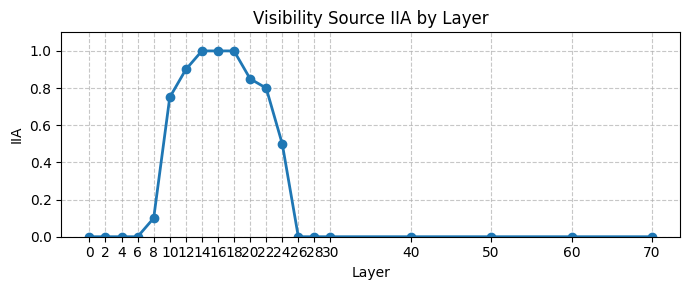

In [14]:
# Visualize accs_vis_source as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_vis_source.keys())
accuracies = list(accs_vis_source.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Visibility Source IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

## Payload

In [15]:
n_samples = 20
batch_size = 1

dataset = get_visibility_lookback_data(
    all_characters,
    all_objects,
    all_states,
    n_samples,
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [16]:
idx = 0
print(dataset[idx]["corrupt_prompt"], dataset[idx]["corrupt_ans"])
print(dataset[idx]["clean_prompt"], dataset[idx]["clean_ans"])
print(f"\nTarget: {dataset[idx]['target']}")

Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any beliefs about the container and its contents which they cannot observe. 4. To answer the question, predict only what is inside the queried container, strictly based on the belief of the character, mentioned in the question. 5. If the queried character has no belief about the container in question, then predict 'unknown'. 6. Do not predict container or character as the final output.

Story: Ray and Liz are working in a busy restaurant. To complete an order, Ray grabs an opaque container and fills it with coffee. Then Liz grabs another opaque pitcher and fills it with cocoa. Liz cannot observe Ray's actions. Ray can observe Liz's actions.
Question: What does Ray believe the pitcher contains?
Answer: cocoa
Instruction: 1. Track the belief of each character as desc

In [17]:
_, errors = error_detection(model, dataloader, is_remote)

100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


In [19]:
accs_vis_payload = {}
patch_layers = (
    [i for i in range(0, 40, 10)]
    + [i for i in range(32, 62, 2)]
    + [i for i in range(70, model.config.num_hidden_layers, 10)]
)

for layer_idx in patch_layers:
    correct, total = 0, 0

    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        if bi in errors:
            continue
        corrupt_prompt = batch["corrupt_prompt"][0]
        clean_prompt = batch["clean_prompt"][0]
        target = batch["target"][0]

        corrupt_out = defaultdict(dict)
        with model.session():
            with model.trace(corrupt_prompt):
                for t_idx, t in enumerate(query_sent):
                    corrupt_out[t_idx] = (
                        model.model.layers[layer_idx].output[0][0, t].clone()
                    )

            with model.trace(clean_prompt):
                for t_idx, t in enumerate(query_sent):
                    model.model.layers[layer_idx].output[0][0, t] = corrupt_out[t_idx]

                pred = model.lm_head.output[0, -1].argmax(dim=-1).save()

        # print(f"Pred: {model.tokenizer.decode([pred]).lower().strip()} | Target: {target}")
        if model.tokenizer.decode([pred]).lower().strip() == target.lower().strip():
            correct += 1
        total += 1

        del pred, corrupt_out
        torch.cuda.empty_cache()

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_vis_payload[layer_idx] = acc

100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


Layer: 0 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


Layer: 10 | Accuracy: 0.05


100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


Layer: 20 | Accuracy: 0.0


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Layer: 30 | Accuracy: 0.11


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Layer: 32 | Accuracy: 0.79


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Layer: 34 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Layer: 36 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


Layer: 38 | Accuracy: 1.0


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Layer: 40 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


Layer: 42 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Layer: 44 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


Layer: 46 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


Layer: 48 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


Layer: 50 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.54it/s]


Layer: 52 | Accuracy: 0.79


100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


Layer: 54 | Accuracy: 0.21


100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


Layer: 56 | Accuracy: 0.05


100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Layer: 58 | Accuracy: 0.0


100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


Layer: 60 | Accuracy: 0.0


100%|██████████| 20/20 [00:13<00:00,  1.47it/s]

Layer: 70 | Accuracy: 0.0


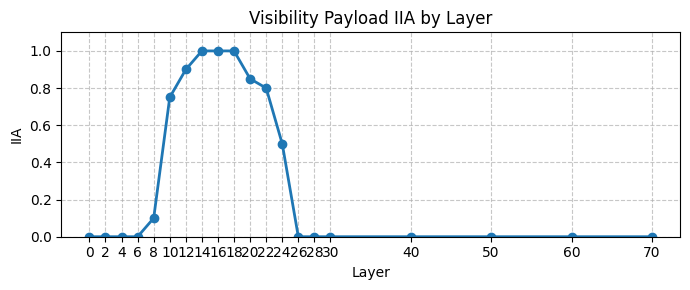

In [20]:
# Visualize accs_vis_source as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_vis_source.keys())
accuracies = list(accs_vis_source.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Visibility Payload IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

## Source and Pointer

In [28]:
n_samples = 20
batch_size = 1

dataset = get_visibility_lookback_data(
    all_characters,
    all_objects,
    all_states,
    n_samples,
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [29]:
idx = 0
print(dataset[idx]["corrupt_prompt"], dataset[idx]["corrupt_ans"])
print(dataset[idx]["clean_prompt"], dataset[idx]["clean_ans"])
print(f"\nTarget: {dataset[idx]['target']}")

Instruction: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any beliefs about the container and its contents which they cannot observe. 4. To answer the question, predict only what is inside the queried container, strictly based on the belief of the character, mentioned in the question. 5. If the queried character has no belief about the container in question, then predict 'unknown'. 6. Do not predict container or character as the final output.

Story: Oscar and Jake are working in a busy restaurant. To complete an order, Oscar grabs an opaque flute and fills it with ale. Then Jake grabs another opaque can and fills it with cocktail. Jake cannot observe Oscar's actions. Oscar can observe Jake's actions.
Question: What does Oscar believe the can contains?
Answer: cocktail
Instruction: 1. Track the belief of each character as

In [30]:
_, errors = error_detection(model, dataloader, is_remote)

100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


In [36]:
accs_vis_address_pointer = {}
patch_layers = [i for i in range(0, 62, 2)] + [
    i for i in range(70, model.config.num_hidden_layers, 10)
]

for layer_idx in patch_layers:
    correct, total = 0, 0

    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        if bi in errors:
            continue
        corrupt_prompt = batch["corrupt_prompt"][0]
        clean_prompt = batch["clean_prompt"][0]
        target = batch["target"][0]

        corrupt_out = defaultdict(dict)
        with model.session():
            with model.trace(corrupt_prompt):
                for t_idx, t in enumerate(second_visibility_sent + query_sent):
                    corrupt_out[t_idx] = (
                        model.model.layers[layer_idx].output[0][0, t].clone()
                    )

            with model.trace(clean_prompt):
                for t_idx, t in enumerate(second_visibility_sent + query_sent):
                    model.model.layers[layer_idx].output[0][0, t] = corrupt_out[t_idx]

                pred = model.lm_head.output[0, -1].argmax(dim=-1).save()

        # print(f"Pred: {model.tokenizer.decode([pred]).lower().strip()} | Target: {target}")
        if model.tokenizer.decode([pred]).lower().strip() == target.lower().strip():
            correct += 1
        total += 1

        del pred, corrupt_out
        torch.cuda.empty_cache()

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_vis_address_pointer[layer_idx] = acc

100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


Layer: 0 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


Layer: 2 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


Layer: 4 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


Layer: 6 | Accuracy: 0.32


100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


Layer: 8 | Accuracy: 0.58


100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


Layer: 10 | Accuracy: 0.63


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


Layer: 12 | Accuracy: 0.89


100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


Layer: 14 | Accuracy: 1.0


100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


Layer: 16 | Accuracy: 1.0


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Layer: 18 | Accuracy: 1.0


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 20 | Accuracy: 1.0


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


Layer: 22 | Accuracy: 1.0


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 24 | Accuracy: 1.0


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Layer: 26 | Accuracy: 1.0


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


Layer: 28 | Accuracy: 1.0


100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Layer: 30 | Accuracy: 1.0


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


Layer: 32 | Accuracy: 1.0


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Layer: 34 | Accuracy: 1.0


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


Layer: 36 | Accuracy: 1.0


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


Layer: 38 | Accuracy: 1.0


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


Layer: 40 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


Layer: 42 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


Layer: 44 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


Layer: 46 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


Layer: 48 | Accuracy: 1.0


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


Layer: 50 | Accuracy: 1.0


100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


Layer: 52 | Accuracy: 0.95


100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


Layer: 54 | Accuracy: 0.32


100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


Layer: 56 | Accuracy: 0.05


100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


Layer: 58 | Accuracy: 0.0


100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


Layer: 60 | Accuracy: 0.0


100%|██████████| 20/20 [00:13<00:00,  1.45it/s]

Layer: 70 | Accuracy: 0.0


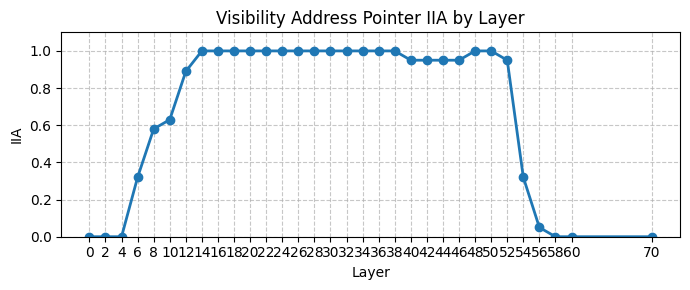

In [38]:
# Visualize accs_vis_address_pointer as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_vis_address_pointer.keys())
accuracies = list(accs_vis_address_pointer.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Visibility Address Pointer IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Attention Knockout

In [22]:
n_rep = model.config.num_key_value_heads
n_heads = model.config.num_attention_heads
head_dim = model.config.hidden_size // model.config.num_attention_heads


def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : head_dim // 2]
    x2 = x[..., head_dim // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    X = hidden_states.shape
    batch, num_key_value_heads, slen, head_dim = X[0], X[1], X[2], X[3]
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(
        batch, num_key_value_heads, n_rep, slen, head_dim
    )
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

In [23]:
def apply_causal_mask(attn_scores, knockout_mask=None):
    ignore = torch.tensor(torch.finfo(torch.float16).min)

    # Apply causal mask
    mask = torch.triu(
        torch.ones(
            attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device
        ),
        diagonal=1,
    ).bool()
    attn_scores.masked_fill_(mask, ignore)

    attn_scores.masked_fill_(knockout_mask.to(attn_scores.device), ignore)

    return attn_scores

In [33]:
knockout = {}
for t in second_visibility_sent:
    knockout[t] = second_sent.copy()
    # knockout[t] += first_visibility_sent.copy()

# Create source and target indices tensors
batch_size = 1
num_heads = model.config.num_attention_heads
tokens = model.tokenizer(dataset[0]["corrupt_prompt"], return_tensors="pt")["input_ids"]
q_len = tokens.size(1)

# Create a mask of zeros with the shape as batch_size, num_heads, q_len, q_len
knockout_mask = torch.zeros(
    batch_size, num_heads, q_len, q_len, device=model.device, dtype=torch.bool
)

# Expand indices for broadcasting
# We create pairs of (from_pos, to_pos) for every entry in the knockout dict
from_indices = []
to_indices = []

for from_pos, to_pos_list in knockout.items():
    for to_pos in to_pos_list:
        from_indices.append(from_pos)
        to_indices.append(to_pos)

# Convert to tensors
from_indices = torch.tensor(from_indices)
to_indices = torch.tensor(to_indices)

# Create indices for each batch and head
for b in range(1, batch_size):
    knockout_mask[b, :, from_indices, to_indices] = True

# Set all heads for first batch
for h in range(num_heads):
    knockout_mask[0, h, from_indices, to_indices] = True

In [34]:
patch_layers = [i for i in range(35)] + [i for i in range(40, 80, 10)]

In [35]:
accs_knockout_3 = {}
for layer_idx in patch_layers:
    correct, total = 0, 0
    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        if bi in errors or bi >= 80:
            continue
        prompt = batch["corrupt_prompt"][0]
        ans = batch["corrupt_ans"][0]
        input_tokens = model.tokenizer(prompt, return_tensors="pt").input_ids
        bsz, q_len = input_tokens.shape
        positions = torch.arange(q_len)
        positions = torch.tensor(positions).unsqueeze(0).repeat(bsz, 1)

        with torch.no_grad():
            with model.trace(prompt) as tracer:
                for l in range(layer_idx, model.config.num_hidden_layers):
                    query_states = model.model.layers[l].self_attn.q_proj.output
                    key_states = model.model.layers[l].self_attn.k_proj.output
                    value_states = model.model.layers[l].self_attn.v_proj.output

                    query_states = query_states.view(
                        bsz, q_len, -1, head_dim
                    ).transpose(1, 2)
                    key_states = key_states.view(bsz, q_len, -1, head_dim).transpose(
                        1, 2
                    )
                    value_states = value_states.view(
                        bsz, q_len, -1, head_dim
                    ).transpose(1, 2)

                    X = model.model.rotary_emb(value_states, positions)
                    cos, sin = X[0], X[1]
                    X = apply_rotary_pos_emb(
                        q=query_states, k=key_states, cos=cos, sin=sin
                    )
                    query_states, key_states = X[0], X[1]

                    key_states = repeat_kv(key_states, n_rep)
                    value_states = repeat_kv(value_states, n_rep)

                    attn_weights = torch.matmul(
                        query_states, key_states.transpose(2, 3)
                    ) / math.sqrt(head_dim)
                    attn_weights = apply_causal_mask(
                        attn_scores=attn_weights,
                        knockout_mask=knockout_mask,
                    )

                    attn_weights = torch.nn.functional.softmax(attn_weights, dim=-1)
                    attn_weights = torch.nn.functional.dropout(
                        attn_weights, p=0.0, training=False
                    )
                    attn_output = torch.matmul(attn_weights, value_states)
                    attn_output = attn_output.transpose(1, 2).contiguous()
                    attn_output = attn_output.reshape(bsz, q_len, -1)

                    model.model.layers[l].self_attn.o_proj.input = attn_output

                pred = model.lm_head.output[:, -1].argmax(dim=-1).item().save()

            # print(f"Prediction: {model.tokenizer.decode([pred]).lower().strip()} | Target: {ans}")
            if model.tokenizer.decode([pred]).lower().strip() == ans:
                correct += 1
            total += 1

    print(f"Layer: {layer_idx} | Accuracy: {round(correct / total, 2)}")
    accs_knockout_3[layer_idx] = round(correct / total, 2)

    with open("../accs_knockout_3.json", "w") as f:
        json.dump(accs_knockout_3, f, indent=4)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:31<00:00,  1.10it/s]


Layer: 0 | Accuracy: 0.35


100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


Layer: 1 | Accuracy: 0.35


100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


Layer: 2 | Accuracy: 0.36


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


Layer: 3 | Accuracy: 0.36


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


Layer: 4 | Accuracy: 0.36


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Layer: 5 | Accuracy: 0.36


100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Layer: 6 | Accuracy: 0.38


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


Layer: 7 | Accuracy: 0.39


100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Layer: 8 | Accuracy: 0.41


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Layer: 9 | Accuracy: 0.41


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Layer: 10 | Accuracy: 0.41


100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Layer: 11 | Accuracy: 0.41


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


Layer: 12 | Accuracy: 0.41


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Layer: 13 | Accuracy: 0.42


100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


Layer: 14 | Accuracy: 0.42


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


Layer: 15 | Accuracy: 0.44


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Layer: 16 | Accuracy: 0.45


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


Layer: 17 | Accuracy: 0.45


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


Layer: 18 | Accuracy: 0.5


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


Layer: 19 | Accuracy: 0.55


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Layer: 20 | Accuracy: 0.56


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Layer: 21 | Accuracy: 0.56


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


Layer: 22 | Accuracy: 0.71


100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


Layer: 23 | Accuracy: 0.79


100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Layer: 24 | Accuracy: 0.89


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


Layer: 25 | Accuracy: 0.89


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


Layer: 26 | Accuracy: 0.92


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


Layer: 27 | Accuracy: 0.97


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


Layer: 28 | Accuracy: 0.97


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Layer: 29 | Accuracy: 0.97


100%|██████████| 100/100 [01:09<00:00,  1.45it/s]


Layer: 30 | Accuracy: 0.98


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Layer: 31 | Accuracy: 0.98


100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Layer: 32 | Accuracy: 0.98


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Layer: 33 | Accuracy: 0.98


100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


Layer: 34 | Accuracy: 0.98


100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Layer: 40 | Accuracy: 1.0


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Layer: 50 | Accuracy: 1.0


100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


Layer: 60 | Accuracy: 1.0


100%|██████████| 100/100 [00:27<00:00,  3.58it/s]

Layer: 70 | Accuracy: 1.0


In [27]:
# Sort accs_knockout by layer index
accs_knockout = dict(sorted(accs_knockout.items(), key=lambda x: x[0]))
accs_knockout

{0: 0.05,
 1: 0.05,
 2: 0.05,
 3: 0.06,
 4: 0.06,
 5: 0.06,
 6: 0.06,
 7: 0.05,
 8: 0.05,
 9: 0.05,
 10: 0.05,
 11: 0.05,
 12: 0.03,
 13: 0.02,
 14: 0.02,
 15: 0.03,
 16: 0.02,
 17: 0.03,
 18: 0.03,
 19: 0.05,
 20: 0.09,
 21: 0.08,
 22: 0.15,
 23: 0.2,
 24: 0.45,
 25: 0.62,
 26: 0.73,
 27: 0.74,
 28: 0.88,
 29: 0.97,
 30: 0.97,
 31: 0.97,
 32: 0.98,
 33: 0.98,
 34: 1.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0}

In [32]:
# Sort accs_knockout by layer index
accs_knockout = dict(sorted(accs_knockout.items(), key=lambda x: x[0]))
accs_knockout

{0: 0.0,
 5: 0.0,
 10: 0.0,
 15: 0.0,
 20: 0.0,
 25: 0.47,
 26: 0.84,
 27: 0.95,
 28: 0.95,
 29: 0.95,
 30: 0.95}

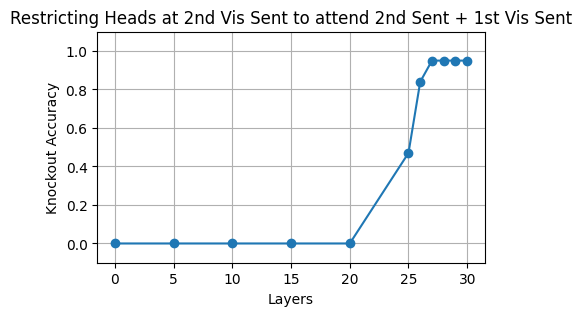

In [36]:
# Visualize accs using a line plot
plt.figure(figsize=(5, 3))
plt.plot(accs_knockout.keys(), accs_knockout.values(), marker="o")
plt.xlabel("Layers")
plt.ylabel("Knockout Accuracy")
plt.title("Restricting Heads at 2nd Vis Sent to attend 2nd Sent + 1st Vis Sent")
plt.ylim(-0.1, 1.1)
plt.grid()
plt.show()

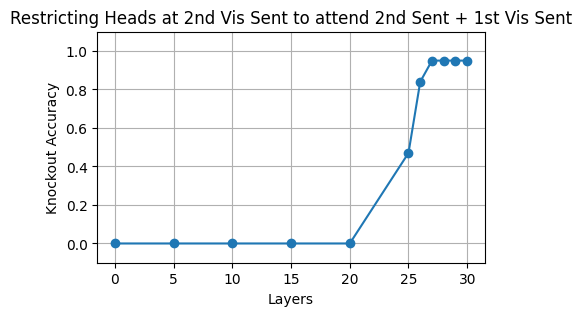

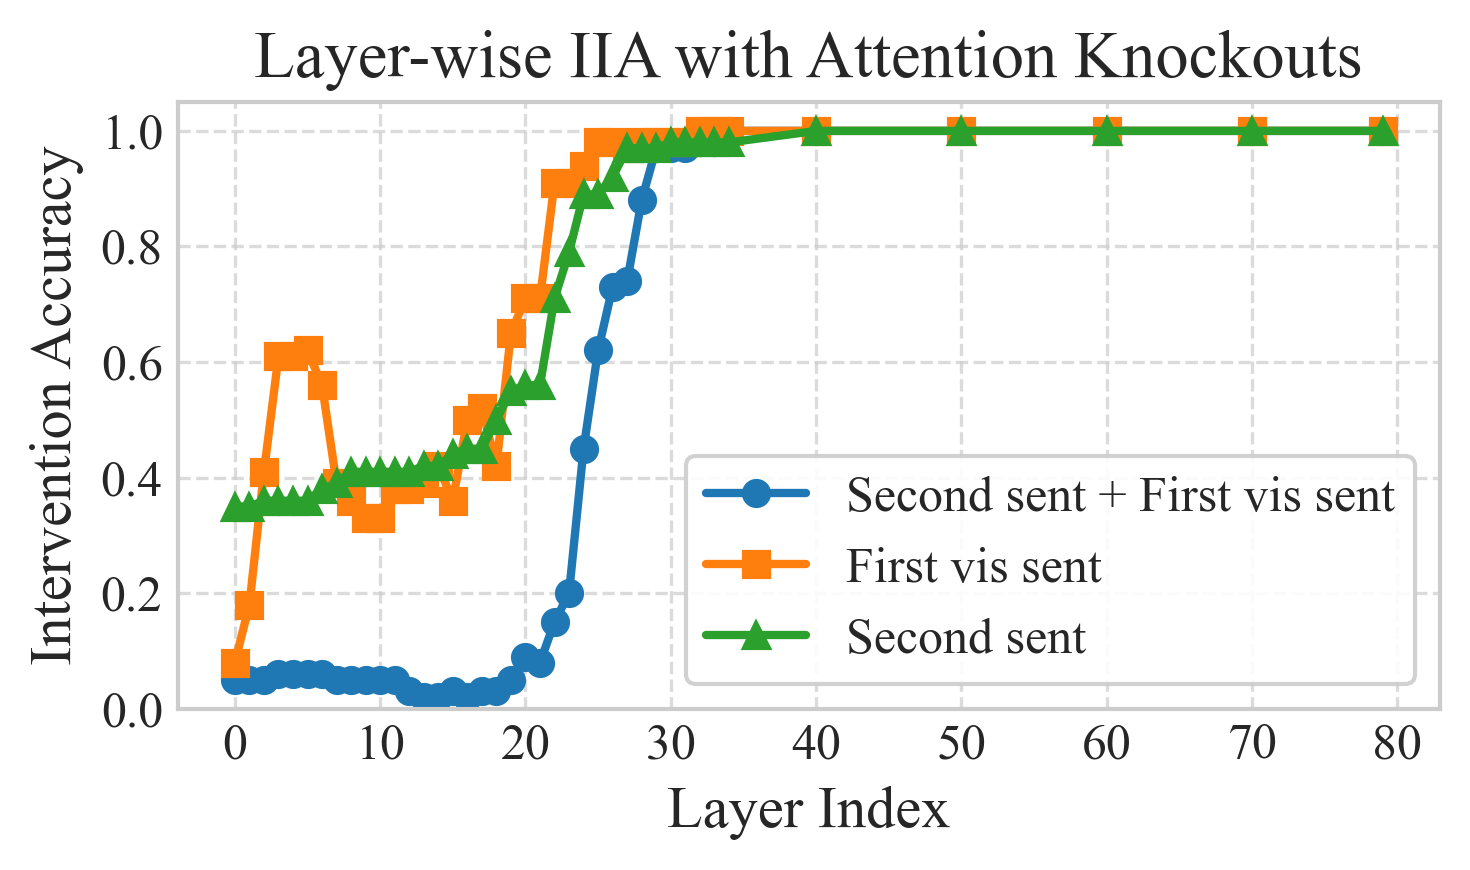

In [14]:
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Set up the plot style for publication quality
plt.style.use("seaborn-v0_8-whitegrid")
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["figure.titlesize"] = 16

# Load the data
with open("../accs_knockout.json", "r") as f:
    data1 = json.load(f)

with open("../accs_knockout_2.json", "r") as f:
    data2 = json.load(f)

with open("../accs_knockout_3.json", "r") as f:
    data3 = json.load(f)

# Convert to lists for plotting
layers1 = [int(k) for k in data1.keys()]
accuracy1 = [float(v) for v in data1.values()]

layers2 = [int(k) for k in data2.keys()]
accuracy2 = [float(v) for v in data2.values()]

layers3 = [int(k) for k in data3.keys()]
accuracy3 = [float(v) for v in data3.values()]

# Sort by layer number
sorted_data1 = sorted(zip(layers1, accuracy1))
sorted_data2 = sorted(zip(layers2, accuracy2))
sorted_data3 = sorted(zip(layers3, accuracy3))

layers1, accuracy1 = zip(*sorted_data1)
layers2, accuracy2 = zip(*sorted_data2)
layers3, accuracy3 = zip(*sorted_data3)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)

# Plot the data with different line styles and markers
ax.plot(
    layers1,
    accuracy1,
    "o-",
    color="#1f77b4",
    linewidth=2,
    markersize=6,
    label="Second sent + First vis sent",
)
ax.plot(
    layers2,
    accuracy2,
    "s-",
    color="#ff7f0e",
    linewidth=2,
    markersize=6,
    label="First vis sent",
)
ax.plot(
    layers3,
    accuracy3,
    "^-",
    color="#2ca02c",
    linewidth=2,
    markersize=6,
    label="Second sent",
)

# Customize the plot
ax.set_xlabel("Layer Index")
ax.set_ylabel("Intervention Accuracy")
ax.set_title("Layer-wise IIA with Attention Knockouts")

# Set the x-axis to only show integer values
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Add a grid for better readability
ax.grid(True, linestyle="--", alpha=0.7)

# Ensure y-axis starts from 0 and goes to 1.0
ax.set_ylim(0, 1.05)

# Enhance the legend
ax.legend(loc="lower right", frameon=True, framealpha=0.9)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure in high resolution
plt.savefig("../plots/knockout_results.png", dpi=300, bbox_inches="tight")
plt.savefig("../plots/knockout_results.pdf", bbox_inches="tight")

plt.show()